# Cold ions: improving the performance of single-qubit gates
**Increasing robustness against dephasing and control noise using Q-CTRL pulses**

BOULDER OPAL enables you to optimize controls to achieve a target operation on your cold ion hardware. In this guide, you'll find the steps needed to obtain control solutions for individual trapped ions. You'll learn how to optimize controls for robustness to control errors and frequency detuning errors, and how to verify the controls' robustness. In the final part, you'll learn about experimental validation of our control methods.

## Imports and initialization

In [1]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from qctrlopencontrols import new_primitive_control
from qctrlvisualizer import get_qctrl_style, plot_controls

# Q-CTRL imports
from qctrl import Qctrl

plt.style.use(get_qctrl_style())

qctrl = Qctrl()

## Creating Q-CTRL robust single-ion gates

You can use optimization in BOULDER OPAL to obtain a control $\pi$ pulse for a single qubit which is optimized for robustness to both dephasing and control noise.

The total Hamiltonian of the driven single-ion quantum system is:

$$ H(t) = \frac{1 + \beta_\gamma (t)}{2}\left( \gamma(t)\sigma_- + \gamma^*(t)\sigma_+ \right) + \eta(t) \sigma_z, $$

where $\beta_\gamma(t)$ is a fractional time-dependent amplitude fluctuation process, $\eta(t)$ is a small, slowly-varying stochastic dephasing noise process and $\sigma_k$ are the Pauli matrices. The time-dependent microwave drive $\gamma(t) = \Omega e^{i \phi}$ has Rabi rate $\Omega$ and phase $\phi$.

The first step to set up the optimization is to define basic operators and parameters.

In [2]:
# Define standard matrices
identity = np.array([[1.0, 0.0], [0.0, 1.0]], dtype=np.complex)
sigma_z = np.array([[1.0, 0.0], [0.0, -1.0]], dtype=np.complex)
sigma_x = np.array([[0.0, 1.0], [1.0, 0.0]], dtype=np.complex)
sigma_m = np.array([[0.0, 1.0], [0.0, 0.0]], dtype=np.complex)

# Define physical constants
omega_max = 2 * np.pi * 6.0e3  # Hz

### Generating a primitive benchmark pulse

Obtain a benchmark pulse using the 'primitive' control scheme available from [Q-CTRL Open Controls](https://q-ctrl.com/products/open-controls/).

In [3]:
scheme = "primitive"
total_rotation = np.pi
azimuthal_angle = 0

# Load OpenControl pulse
pulse = new_primitive_control(
    rabi_rotation=total_rotation,
    azimuthal_angle=azimuthal_angle,
    maximum_rabi_rate=omega_max,
    name=scheme,
)

# Export pulse segments
drive_segments = [
    {"duration": d, "value": v}
    for d, v in zip(
        pulse.durations, pulse.rabi_rates * np.exp(+1j * pulse.azimuthal_angles)
    )
]

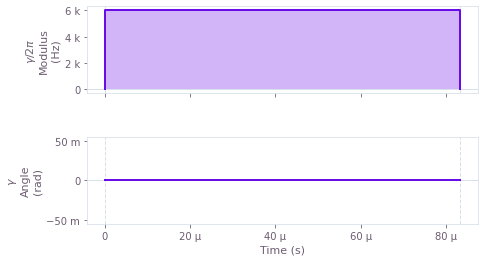

In [4]:
plot_controls(plt.figure(), {"$\gamma$": drive_segments})
plt.show()

The figure is a visualization of the modulus $\Omega$ and phase (or angle) $\phi$ of the primitive drive $\gamma(t)$, which is a square pulse.

### Generating an optimized robust pulse

To optimize your control `pulses`, you first need to parametrize them. In this optimization, each pulse is treated as a piecewise-constant function made of a set of `segments`. Each `segment` has a `duration` in time and a `real`/`complex` `value` that is held constant. You can also explore parametrization options in the [Optimization](https://docs.q-ctrl.com/boulder-opal/user-guides/optimization) User guide. After you set up the optimization specifications, such as a fixed modulus for the drive in the following cell, you can generate and visualize the optimized controls. A cost value close to zero indicates that the optimizer was able to find effective controls to perform the desired gate.

  0%|          | 0/100 [00:02<?, ?it/s]

Your task calculate_optimization is currently in a queue waiting to be processed.


  0%|          | 0/100 [00:04<?, ?it/s]

Your task calculate_optimization has started.


100%|██████████| 100/100 [00:05<00:00, 17.41it/s]

Cost: 3.4714816107568535e-11


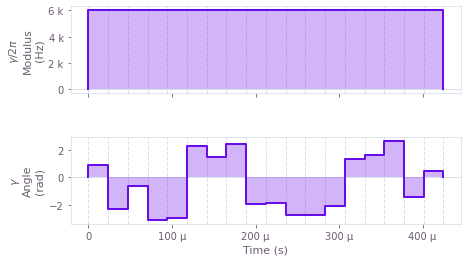

In [5]:
# Optimization inputs
segment_count = 18
duration = 425.0e-6  # s

with qctrl.create_graph() as graph:

    # Create a complex PWC signal, with fixed modulus and optimizable phase,
    # representing gamma(t)
    gamma = qctrl.operations.complex_pwc_signal(
        moduli=np.full((segment_count), omega_max),
        phases=qctrl.operations.unbounded_optimization_variable(
            count=segment_count,
            initial_lower_bound=0,
            initial_upper_bound=2 * np.pi,
        ),
        duration=duration,
        name="gamma",
    )

    # Create a PWC operator representing the drive term
    drive = qctrl.operations.pwc_operator_hermitian_part(
        qctrl.operations.pwc_operator(signal=gamma, operator=sigma_m)
    )

    # Create a constant PWC operator representing the dephasing noise
    # (note that we scale by 1/duration to ensure consistent units between
    # the noise Hamiltonian and the control Hamiltonian)
    dephasing = qctrl.operations.constant_pwc_operator(
        duration=duration, operator=sigma_z / duration
    )

    # Create the target operator
    target_operator = qctrl.operations.target(operator=sigma_x)

    # Create infidelity
    infidelity = qctrl.operations.infidelity_pwc(
        hamiltonian=drive,
        noise_operators=[dephasing, drive],
        target_operator=target_operator,
        name="infidelity",
    )

optimization_result = qctrl.functions.calculate_optimization(
    cost_node_name="infidelity",
    output_node_names=["gamma"],
    graph=graph,
)

print("Cost:", optimization_result.cost)

optimized_controls = {"$\gamma$": optimization_result.output["gamma"]}
plot_controls(plt.figure(), optimized_controls)
plt.show()

The modulus and angle of the optimized control are displayed above.

### Robustness verification with quasi-static scans

You can verify the control robustness using 1D quasi-static scans of control and dephasing noise. These scans are characterized by the coefficients $\beta_\gamma(t)\equiv \beta_\gamma$ and $\eta(t)\equiv\eta$, respectively. The infidelity of the operation is calculated with the given noise value. Note that the operation is defined differently for each scan: for the control amplitude scan the $\pi$ rotation is repeated ten times, whereas for the dephasing scan the ten $\pi$ pulses are repeated with alternating direction of rotation about the Bloch sphere. These concatenated operations amplify the effects of the respective errors from the primitive and optimized pulses.

In [6]:
# Quasi-static function parameters
amplitude_coefficients = np.linspace(-0.1, 0.1, 41)
dephasing_coefficients = np.linspace(-0.1, 0.1, 41) * omega_max

# Define the target
target = qctrl.types.TargetInput(operator=identity)

# Evaluate quasi-static scans
schemes = ["Primitive", "Optimized"]
drives = [drive_segments, optimization_result.output["gamma"]]
durations = [10 * drive_segments[0]["duration"], 10 * duration]
quasi_static_functions = {}

for scheme, scan_drive, scan_duration in zip(schemes, drives, durations):
    quasi_static_functions[scheme] = []

    # Define repeated drive term
    repeated_drive = scan_drive * 10
    drive = qctrl.types.quasi_static_scan.Drive(
        control=[
            qctrl.types.ComplexSegmentInput(
                duration=segment["duration"], value=segment["value"]
            )
            for segment in repeated_drive
        ],
        operator=sigma_m / 2,
        noise=qctrl.types.quasi_static_scan.Noise(
            name="drive noise",
            values=amplitude_coefficients,
        ),
    )

    # Calculate the quasi-static amplitude scan
    quasi_static_functions[scheme].append(
        qctrl.functions.calculate_quasi_static_scan(
            duration=scan_duration,
            drives=[drive],
            target=target,
        )
    )

    # Define alternating drive term
    scan_drive_r = [
        {"duration": d, "value": -v}
        for v, d in [(segment["value"], segment["duration"]) for segment in scan_drive]
    ]
    alternating_drive = list(np.array([scan_drive, scan_drive_r] * 5).flatten())
    drive = qctrl.types.quasi_static_scan.Drive(
        control=[
            qctrl.types.ComplexSegmentInput(
                duration=segment["duration"], value=segment["value"]
            )
            for segment in alternating_drive
        ],
        operator=sigma_m / 2,
    )

    # Define dephasing drift term
    dephasing_drift = qctrl.types.quasi_static_scan.Drift(
        operator=sigma_z / 2,
        noise=qctrl.types.quasi_static_scan.Noise(
            name="dephasing noise",
            values=dephasing_coefficients,
        ),
    )

    # Calculate the quasi-static dephasing scan
    quasi_static_functions[scheme].append(
        qctrl.functions.calculate_quasi_static_scan(
            duration=scan_duration,
            drives=[drive],
            drifts=[dephasing_drift],
            target=target,
        )
    )

  0%|          | 0/100 [00:02<?, ?it/s]

Your task calculate_quasi_static_scan is currently in a queue waiting to be processed.


100%|██████████| 100/100 [00:02<00:00, 34.55it/s]


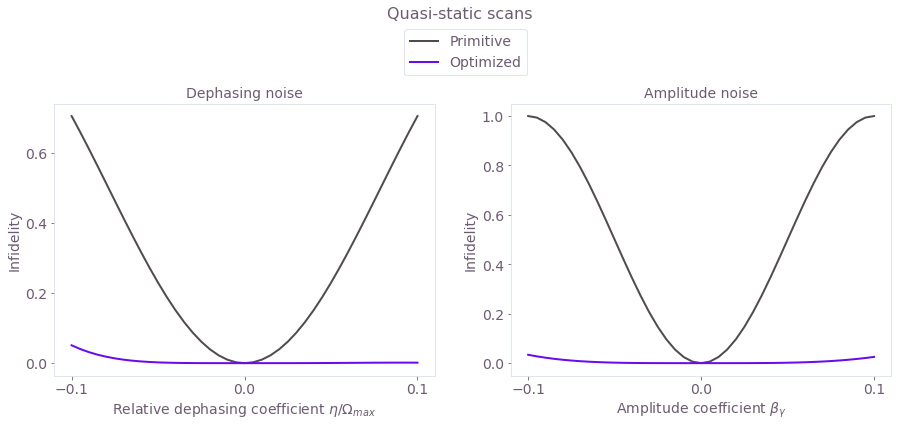

In [7]:
# Plot resulting scans
colors = ["#514B4F", "#680CE9"]
gs = gridspec.GridSpec(1, 2)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(3 * 5)
fig.suptitle("Quasi-static scans", fontsize=16, y=1.15)

ax = fig.add_subplot(gs[0])
ax.set_xlabel(r"Relative dephasing coefficient $\eta/\Omega_{max}$", fontsize=14)
ax.set_ylabel("Infidelity", fontsize=14)
ax.set_title("Dephasing noise", fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xticks([-0.1, 0, 0.1])
ax.set_yticks(np.arange(0, 1.1, 0.2))
for idx, scheme in enumerate(schemes):
    infidelities = [
        sample.infidelity for sample in quasi_static_functions[scheme][1].samples
    ]
    noise_values = np.array(
        [
            sample.noise_values[0].value
            for sample in quasi_static_functions[scheme][1].samples
        ]
    )
    ax.plot(
        noise_values / omega_max,
        infidelities,
        label=schemes[idx],
        color=colors[idx],
        linewidth=2,
    )

ax = fig.add_subplot(gs[1])
ax.set_xlabel(r"Amplitude coefficient $\beta_\gamma$", fontsize=14)
ax.set_ylabel("Infidelity", fontsize=14)
ax.set_title("Amplitude noise", fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xticks([-0.1, 0, 0.1])
ax.set_yticks(np.arange(0, 1.1, 0.2))
for idx, scheme in enumerate(schemes):
    infidelities = [
        sample.infidelity for sample in quasi_static_functions[scheme][0].samples
    ]
    noise_values = [
        sample.noise_values[0].value
        for sample in quasi_static_functions[scheme][0].samples
    ]
    plt.plot(
        noise_values, infidelities, label=schemes[idx], color=colors[idx], linewidth=2
    )

ax.legend(loc="best", bbox_to_anchor=(0.06, 1.3), fontsize=14)
plt.show()

The plots demonstrate the different noise susceptibilities (in terms of operational infidelity) of the primitive and optimized controls. The optimized scheme has a much broader high-fidelity region.

## Experimental validation of single-ion gates

In the above section, you verified the robustness of the optimized controls using simulations. Single-ion primitive and robust optimized controls have also been obtained and implemented in experiment. The following figure from (Ball et al., [arXiv:2001.04060](https://arxiv.org/abs/2001.04060)) displays the controls and their observed robustness in experiment. Bloch sphere representations of the controls are shown in (a) and (c), with the corresponding pulse amplitudes and phases in (b) and (d) respectively. The advantage of the optimized pulse is demonstrated in the plots of measured infidelity in (e) and (f), which is the projection of the final state onto the target state.

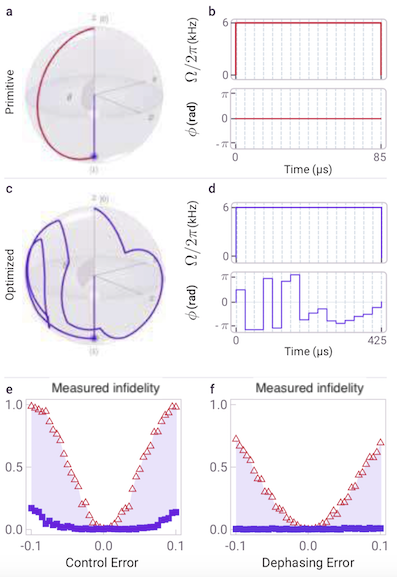

The $x$-axes correspond to the amplitude coefficient $\beta_\gamma$ and the dephasing $\eta / \Omega_{\texttt{max}}$ for (e) and (f) respectively. The shading in these plots represents the net improvement in error robustness afforded by the optimized solution. As for the theoretical analysis above, the control error plot (e) is for ten iterations of the $\pi$ pulses, rotating about the $+X$ axis. The dephasing error plot is similarly for ten iterations of the $\pi$ pulses, but alternately rotating about the $+X$ and $-X$ axes.